# Code slate

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv
/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip


In [2]:
# Import primary functions
import os, re
import string
import bs4
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Import secondary functions
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [3]:
train = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', delimiter='\t')
test = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip', delimiter='\t')

In [4]:
train.shape
test.shape

(25000, 2)

In [5]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [7]:
print("Num of rows for sentiment 1: {}".format(len(train[train.sentiment == 1])))
print("Num of rows for sentiment 0: {}".format(len(train[train.sentiment == 0])))

Num of rows for sentiment 1: 12500
Num of rows for sentiment 0: 12500


In [8]:
train.groupby('sentiment').describe().transpose()

sentiment                                                      0  \
id     count                                               12500   
       unique                                              12500   
       top                                                7759_3   
       freq                                                    1   
review count                                               12500   
       unique                                              12432   
       top     When i got this movie free from my job, along ...   
       freq                                                    3   

sentiment                                                      1  
id     count                                               12500  
       unique                                              12500  
       top                                                5814_8  
       freq                                                    1  
review count                                               12500  
       unique                                              12472  
       top     Everyone knows about this ''Zero Day'' event. ...  
       freq                                                    2

In [9]:
train['length'] = train['review'].apply(len)
train.head()

,id,sentiment,review,length
0,5814_8,1,With all this stuff going down at the moment w...,2302
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2449
3,3630_4,0,It must be assumed that those who praised this...,2245
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2231


# Do the graph

<Axes: ylabel='Frequency'>

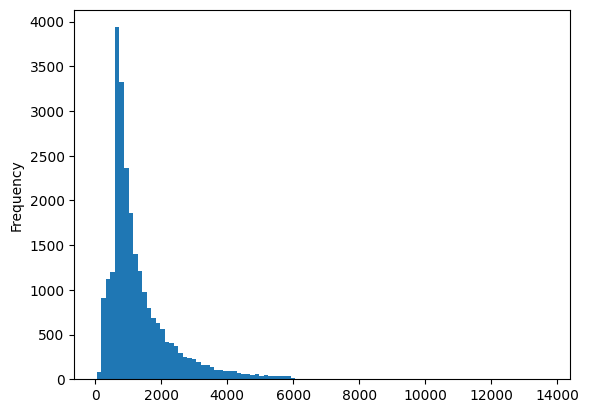

In [10]:
train['length'].plot.hist(bins=100)

In [11]:
train.length.describe()

count    25000.000000
mean      1327.710560
std       1005.239246
min         52.000000
25%        703.000000
50%        981.000000
75%       1617.000000
max      13708.000000
Name: length, dtype: float64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

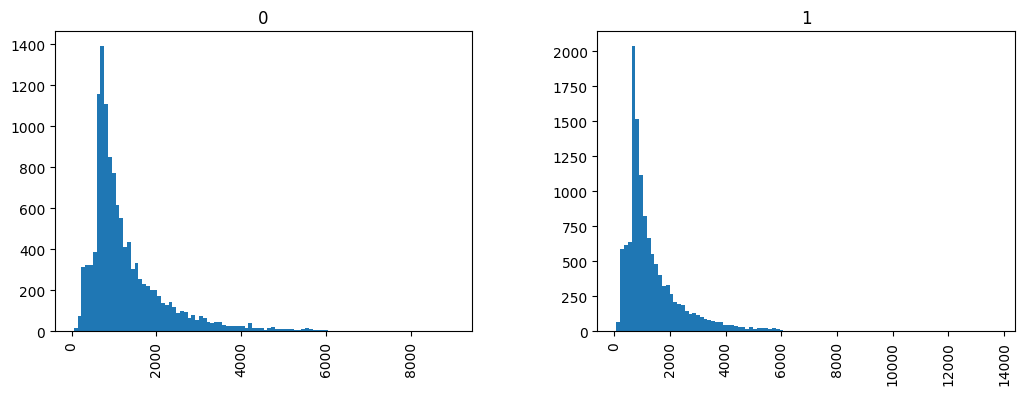

In [12]:
train.hist(column='length', by='sentiment', bins=100, figsize=(12, 4))

In [13]:
def clean_text(raw_text):
    raw_text = BeautifulSoup(raw_text).get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    
    return [w for w in words if not w in stops]

In [14]:
train['clean_review'] = train['review'].apply(clean_text)
train['length_clean_review'] = train['clean_review'].apply(len)

train.head()

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


,id,sentiment,review,length,clean_review,length_clean_review
0,5814_8,1,With all this stuff going down at the moment w...,2302,"[stuff, going, moment, mj, started, listening,...",219
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946,"[classic, war, worlds, timothy, hines, enterta...",84
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2449,"[film, starts, manager, nicholas, bell, giving...",240
3,3630_4,0,It must be assumed that those who praised this...,2245,"[must, assumed, praised, film, greatest, filme...",189
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2231,"[superbly, trashy, wondrously, unpretentious, ...",210


In [15]:
print(train[train['length_clean_review'] == 4]['review'].iloc[0])

print('------Post-filtering------')

print(train[train['length_clean_review'] == 4]['clean_review'].iloc[0])

This movie is terrible but it has some good effects.
------Post-filtering------
['movie', 'terrible', 'good', 'effects']


# Word of fame

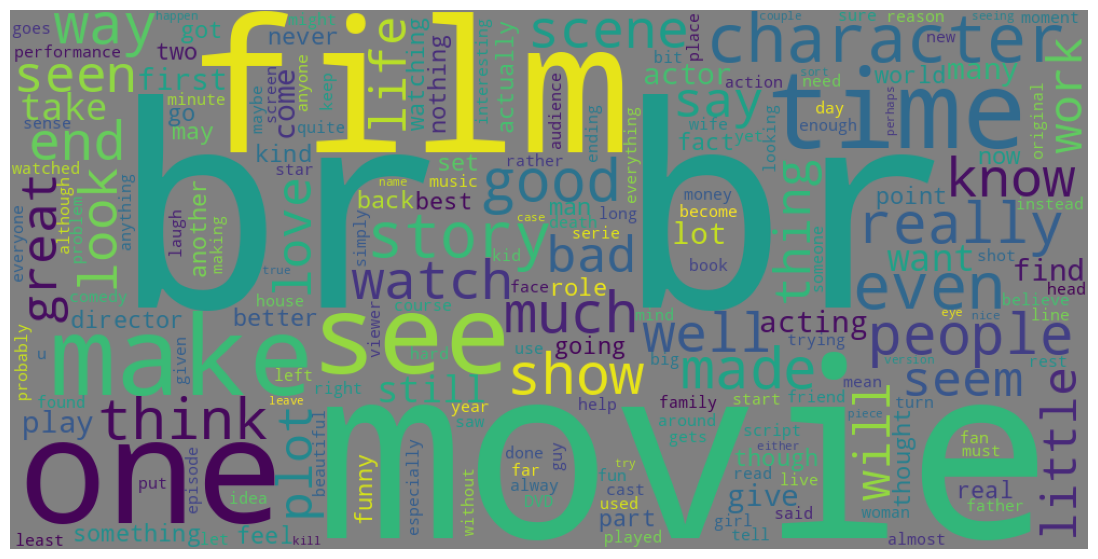

In [16]:
word_cloud = WordCloud(
    width=1000,
    height=500,
    stopwords=STOPWORDS,
    background_color='grey'
).generate(''.join(train['review']))

plt.figure(figsize=(15, 7))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [17]:
bow_transform = CountVectorizer(analyzer=clean_text).fit(train['review'])

print(len(bow_transform.vocabulary_))

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


74065


In [18]:
review1 = train['review'][1]

print(review1)

\The Classic War of the Worlds\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \"critics\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \"critics\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \"critics\" perceive to be its shortcomings."


In [19]:
bow1 = bow_transform.transform([review1])

print(bow1)
print(bow1.shape)

  (0, 1153)	1
  (0, 1860)	1
  (0, 2877)	1
  (0, 5089)	1
  (0, 7345)	2
  (0, 11671)	3
  (0, 12493)	1
  (0, 14613)	1
  (0, 14617)	3
  (0, 14782)	1
  (0, 17310)	1
  (0, 19658)	1
  (0, 19759)	1
  (0, 20008)	2
  (0, 20901)	1
  (0, 21030)	1
  (0, 21035)	2
  (0, 21147)	1
  (0, 21748)	1
  (0, 21754)	1
  (0, 21757)	1
  (0, 22499)	1
  (0, 22584)	1
  (0, 22585)	1
  (0, 22788)	1
  :	:
  (0, 45216)	1
  (0, 45629)	2
  (0, 46521)	1
  (0, 46850)	1
  (0, 48251)	1
  (0, 48288)	1
  (0, 50446)	1
  (0, 51816)	1
  (0, 52690)	1
  (0, 53240)	1
  (0, 54251)	1
  (0, 58936)	1
  (0, 59991)	1
  (0, 61334)	1
  (0, 61943)	1
  (0, 63259)	1
  (0, 65725)	1
  (0, 66191)	1
  (0, 66463)	1
  (0, 70380)	1
  (0, 71340)	1
  (0, 71498)	1
  (0, 71821)	2
  (0, 72911)	1
  (0, 73396)	1
(1, 74065)


In [20]:
review_bow = bow_transform.transform(train['review'])

print('Shape of sparse matrix', review_bow.shape)
print('Amount of non-zero occurence', review_bow.nnz)

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


Shape of sparse matrix (25000, 74065)
Amount of non-zero occurence 2450404


In [21]:
sparsity = (100.0 * review_bow.nnz / (review_bow.shape[0] * review_bow.shape[1]))

print('Sparsity: {}'.format(sparsity))

Sparsity: 0.1323380274083575


In [22]:
tfidf_transformer = TfidfTransformer().fit(review_bow)
tfidf1 = tfidf_transformer.transform(bow1)

print(tfidf1)

  (0, 73396)	0.061582405387422844
  (0, 72911)	0.10916204090045824
  (0, 71821)	0.24678226776886478
  (0, 71498)	0.06130848347869254
  (0, 71340)	0.07054912976037264
  (0, 70380)	0.06691025207731116
  (0, 66463)	0.08376908496574231
  (0, 66191)	0.11391853286104583
  (0, 65725)	0.05408056138661737
  (0, 63259)	0.1047755178999042
  (0, 61943)	0.08811567227327795
  (0, 61334)	0.11302952635114163
  (0, 59991)	0.10986956065151147
  (0, 58936)	0.11997053429431336
  (0, 54251)	0.11268631063864525
  (0, 53240)	0.13073660913364496
  (0, 52690)	0.0824732205199774
  (0, 51816)	0.05986262652464556
  (0, 50446)	0.077539268028452
  (0, 48288)	0.13122486190259133
  (0, 48251)	0.04143735557967593
  (0, 46850)	0.11689701180182505
  (0, 46521)	0.06665775481300043
  (0, 45629)	0.14376840111740952
  (0, 45216)	0.08006252757098449
  :	:
  (0, 22788)	0.10110289576849556
  (0, 22585)	0.13850169616266522
  (0, 22584)	0.10403788202119751
  (0, 22499)	0.05424308473387671
  (0, 21757)	0.06083289839379746
  (0, 2

In [23]:
print(tfidf_transformer.idf_[bow_transform.vocabulary_['war']])
print(tfidf_transformer.idf_[bow_transform.vocabulary_['book']])

4.070495818949949
3.8577509748566374


In [24]:
review_tfidf = tfidf_transformer.transform(review_bow)

print(review_tfidf.shape)

(25000, 74065)


# Extreme measures

## Data train phase

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    train['review'],
    train['sentiment'],
    test_size=0.22,
    random_state=101
)

len(X_train), len(X_test), len(X_train) + len(X_test)

(19500, 5500, 25000)

## Prediction and accuracy phase

In [29]:
def pred(predicted, compare):
    cm = pd.crosstab(compare, predicted)
    TN = cm.iloc[0, 0]
    FN = cm.iloc[1, 0]
    TP = cm.iloc[1, 1]
    FP = cm.iloc[0, 1]
    print("Confusion matrix ------>>")
    print(cm)
    print()
    
    print('Classification paradox :------>>')
    print('Accuracy :- ', round(((TP + TN) * 100) / (TP + TN + FP + FN), 2))
    print()
    print('False negative rate :- ', round((FN * 100) / (FN + TP), 2))
    print()
    print('False postive rate :- ',round((FP * 100) / (FP + TN), 2))
    print()
    print(classification_report(compare, predicted))

In [30]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(random_state=101))
])

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_train)

pred(predictions, y_train)

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()
/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


Confusion matrix ------>>
col_0         0     1
sentiment            
0          9042   682
1           499  9277

Classification paradox :------>>
Accuracy :-  93.94

False negative rate :-  5.1

False postive rate :-  7.01

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9724
           1       0.93      0.95      0.94      9776

    accuracy                           0.94     19500
   macro avg       0.94      0.94      0.94     19500
weighted avg       0.94      0.94      0.94     19500



In [31]:
predictions = pipeline.predict(X_test)

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


In [32]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_train)

pred(predictions, y_train)

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()
/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


Confusion matrix ------>>
col_0         0     1
sentiment            
0          9054   670
1           843  8933

Classification paradox :------>>
Accuracy :-  92.24

False negative rate :-  8.62

False postive rate :-  6.89

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      9724
           1       0.93      0.91      0.92      9776

    accuracy                           0.92     19500
   macro avg       0.92      0.92      0.92     19500
weighted avg       0.92      0.92      0.92     19500



In [33]:
predictions = pipeline.predict(X_test)

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


# Special delivery

## Pipeline testing

In [34]:
pipeline_logit = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(random_state=101))
])

pipeline_logit.fit(train['review'], train['sentiment'])

test['sentiment'] = pipeline_logit.predict(test['review'])

/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()
/tmp/ipykernel_34/662096031.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw_text = BeautifulSoup(raw_text).get_text()


In [35]:
test.head

<bound method NDFrame.head of              id                                             review  sentiment
0      12311_10  Naturally in a film who's main themes are of m...          1
1        8348_2  This movie is a disaster within a disaster fil...          0
2        5828_4  All in all, this is a movie for kids. We saw i...          1
3        7186_2  Afraid of the Dark left me with the impression...          1
4       12128_7  A very accurate depiction of small time mob li...          1
...         ...                                                ...        ...
24995   2155_10  Sony Pictures Classics, I'm looking at you! So...          1
24996     59_10  I always felt that Ms. Merkerson had never got...          1
24997    2531_1  I was so disappointed in this movie. I am very...          0
24998    7772_8  From the opening sequence, filled with black a...          1
24999  11465_10  This is a great horror film for people who don...          1

[25000 rows x 3 columns]>

In [36]:
test.columns

Index(['id', 'review', 'sentiment'], dtype='object')

## Final submission

In [37]:
output = test[['id', 'sentiment']]

print(output)

             id  sentiment
0      12311_10          1
1        8348_2          0
2        5828_4          1
3        7186_2          1
4       12128_7          1
...         ...        ...
24995   2155_10          1
24996     59_10          1
24997    2531_1          0
24998    7772_8          1
24999  11465_10          1

[25000 rows x 2 columns]


In [38]:
output.to_csv("submission.csv", index=False, quoting=3, escapechar='\\')

print("Successfully saved as CSV file")

Successfully saved as CSV file
